In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('/workspace/Transformer_OD_TPU'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt

In [3]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

In [4]:
import main

In [5]:
sys.argv = ['main.py', '--coco_path', '/workspace/processed_data', '--num_workers', '0', '--resume', '/workspace/detr_output/checkpoint.pth']

In [6]:
parser = main.get_args_parser()
args = parser.parse_args()

In [7]:
dataset_train = build_dataset(image_set='train', args=args)
dataset_val = build_dataset(image_set='val', args=args)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [8]:
sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.RandomSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, args.batch_size, drop_last=True)

data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                            drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

In [9]:
base_ds = get_coco_api_from_dataset(dataset_val)

In [10]:
first_batch = next(iter(data_loader_train))

(800, 800, 3)
(800, 800, 3)


In [11]:
sample = first_batch[0].tensors[0].cpu().numpy()

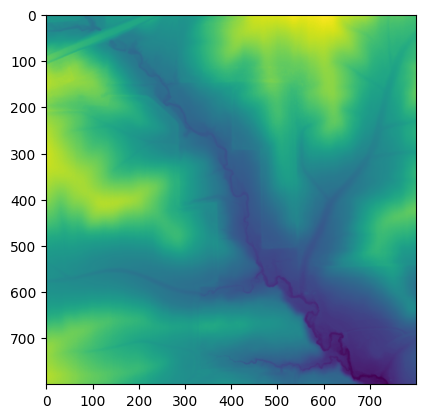

In [12]:
plt.imshow(sample[0,:,:])

In [13]:
print(sample[0,:,:])

[[-0.09986328 -0.09997576 -0.09996919 ... -0.02794058 -0.02836254
  -0.02818362]
 [-0.10017112 -0.10016356 -0.10005963 ... -0.02851448 -0.02879831
  -0.02886902]
 [-0.10029972 -0.1003382  -0.10041022 ... -0.02903445 -0.02970275
  -0.02951858]
 ...
 [ 0.03442467  0.03437303  0.03408559 ... -0.21943846 -0.21870801
  -0.21808837]
 [ 0.03368665  0.03356561  0.03335743 ... -0.22017188 -0.21937038
  -0.21839358]
 [ 0.03279339  0.03248818  0.03227309 ... -0.22060108 -0.21961638
  -0.218881  ]]
